In [1]:
from google.colab import files
uploaded = files.upload()


Saving tab_aml_polars_version_fourtyfour.py to tab_aml_polars_version_fourtyfour.py


In [2]:
from google.colab import drive
drive.flush_and_unmount()


Drive not mounted, so nothing to flush and unmount.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, sys
os.kill(os.getpid(), 9)


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import polars as pl

df = pl.read_csv("/content/drive/MyDrive/AML_Data/SAML-D.csv")
df.head()


Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
str,str,i64,i64,f64,str,str,str,str,str,i64,str
"""10:35:19""","""2022-10-07""",8724731955,2769355426,1459.15,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""
"""10:35:20""","""2022-10-07""",1491989064,8401255335,6019.64,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,"""Normal_Fan_Out"""
"""10:35:20""","""2022-10-07""",287305149,4404767002,14328.44,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,"""Normal_Small_Fan_Out"""
"""10:35:21""","""2022-10-07""",5376652437,9600420220,11895.0,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,"""Normal_Fan_In"""
"""10:35:21""","""2022-10-07""",9614186178,3803336972,115.25,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,"""Normal_Cash_Deposits"""


In [4]:
import torch
from tab_aml_polars_version_fourtyfour import preprocess_saml_d, FocalLoss, fast_hash, recast, collate_encoded_batch, custom_split_polars, TabAMLDataset, TabAMLModel, train_epoch, evaluate, compute_pos_weight, build_weighted_sampler
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn

In [5]:
df = preprocess_saml_d(df)

In [6]:
df = recast(df)

In [7]:
df.head(5)

Date,Sender_account,Receiver_account,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,timestamp,day,month,year,hour,day_of_week,is_weekend,amount_log
date,i64,i64,str,str,str,str,str,i8,datetime[μs],i8,i8,i16,i8,i8,i8,f64
2022-10-07,8724731955,2769355426,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022-10-07 10:35:19,7,10,2022,10,5,1,7.286294
2022-10-07,1491989064,8401255335,"""UK pounds""","""Dirham""","""UK""","""UAE""","""Cross-border""",0,2022-10-07 10:35:20,7,10,2022,10,5,1,8.702949
2022-10-07,287305149,4404767002,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cheque""",0,2022-10-07 10:35:20,7,10,2022,10,5,1,9.570071
2022-10-07,5376652437,9600420220,"""UK pounds""","""UK pounds""","""UK""","""UK""","""ACH""",0,2022-10-07 10:35:21,7,10,2022,10,5,1,9.383957
2022-10-07,9614186178,3803336972,"""UK pounds""","""UK pounds""","""UK""","""UK""","""Cash Deposit""",0,2022-10-07 10:35:21,7,10,2022,10,5,1,4.755743


In [8]:
train_df, val_df, test_df = custom_split_polars(df, validation_days=70, test_days=35)

Split complete:
  Train: 6397772
  Val: 2076692
  Test: 1030388


In [9]:
print(len(train_df), len(val_df), len(test_df))

6397772 2076692 1030388


In [10]:
cat_cols = ["Sender_account", "Receiver_account", "Payment_currency", "Received_currency", "Sender_bank_location",
            "Receiver_bank_location", "Payment_type", "day", "month", "year", "hour", "day_of_week", "is_weekend"]

In [11]:
cont_cols = ["amount_log"]

In [12]:
train_ds = TabAMLDataset(
    train_df, cat_cols, cont_cols, "Is_laundering",
    fit=True,
    hash_growth=1.25,
    hash_cap={"Sender_account": 262_144, "Receiver_account": 1_048_576}
)


In [13]:
val_ds = TabAMLDataset(
    val_df, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [14]:
test_ds = TabAMLDataset(
    test_df, cat_cols, cont_cols, "Is_laundering",
    encoders=train_ds.encoders,
    scaler=train_ds.scaler,
    fit=False,
    hash_bucket_sizes=train_ds.hash_bucket_sizes
)

In [15]:
print("Hash bucket sizes:", train_ds.hash_bucket_sizes)

Hash bucket sizes: {'Receiver_account': 1048576, 'Sender_account': 262144}


In [16]:
print("Unique Sender accounts:", train_df["Sender_account"].n_unique())
print("Unique Receiver accounts:", train_df["Receiver_account"].n_unique())

Unique Sender accounts: 221168
Unique Receiver accounts: 557362


In [17]:
train_sampler = build_weighted_sampler(pl.Series(train_df["Is_laundering"]), power = 0.7)

In [18]:
train_loader  = DataLoader(train_ds, batch_size=512, sampler=train_sampler, collate_fn=collate_encoded_batch)


In [19]:
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [20]:
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_encoded_batch)

In [21]:
model = TabAMLModel(category_sizes=train_ds.category_sizes, cont_dim=len(cont_cols), embedding_dim=48, shared_ratio=1/6, num_heads=4, num_layers1=2, num_layers2=2, dropout=0.25, micro_indices=(0, 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TabAMLModel(
  (embs): ModuleList(
    (0): Embedding(262144, 40)
    (1): Embedding(1048576, 40)
    (2-3): 2 x Embedding(14, 40)
    (4-5): 2 x Embedding(19, 40)
    (6): Embedding(8, 40)
    (7): Embedding(32, 40)
    (8): Embedding(9, 40)
    (9): Embedding(3, 40)
    (10): Embedding(25, 40)
    (11): Embedding(8, 40)
    (12): Embedding(3, 40)
  )
  (micro): ResidualAttentionEncoder(
    (layers): ModuleList(
      (0-1): 2 x ResidualAttentionLayer(
        (qkv): Linear(in_features=48, out_features=144, bias=False)
        (attn_out): Linear(in_features=48, out_features=48, bias=False)
        (ffn): Sequential(
          (0): Linear(in_features=48, out_features=192, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.25, inplace=False)
          (3): Linear(in_features=192, out_features=48, bias=True)
          (4): Dropout(p=0.25, inplace=False)
        )
        (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((

In [22]:
loss_fn = FocalLoss(alpha=0.75, gamma=2.0)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2,  min_lr=1e-6
)

In [23]:
epochs = 30
best_val_auc_pr = 0
patience, bad_epochs = 2, 0

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_auc, val_auc_pr, val_rec, val_prec, val_f1, _ = evaluate(model, val_loader, loss_fn, device)

    scheduler.step(val_auc_pr)

    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | ROC-AUC: {val_auc:.4f} | "
          f"PR-AUC: {val_auc_pr:.4f} | Recall: {val_rec:.3f} | Precision: {val_prec:.3f} | F1: {val_f1:.3f}")

    if val_auc_pr > best_val_auc_pr:
        best_val_auc_pr = val_auc_pr
        torch.save(model.state_dict(), "best_tabaml_model.pt")
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/30 | Train Loss: 0.0196 | Val Loss: 0.0056 | ROC-AUC: 0.7507 | PR-AUC: 0.2284 | Recall: 0.354 | Precision: 0.036 | F1: 0.066
Epoch 2/30 | Train Loss: 0.0106 | Val Loss: 0.0059 | ROC-AUC: 0.7499 | PR-AUC: 0.1980 | Recall: 0.305 | Precision: 0.057 | F1: 0.096
Epoch 3/30 | Train Loss: 0.0094 | Val Loss: 0.0067 | ROC-AUC: 0.7535 | PR-AUC: 0.1877 | Recall: 0.261 | Precision: 0.079 | F1: 0.121
Early stopping triggered.


In [29]:
@torch.no_grad()
def pick_threshold_by(val_loader, model, device, criterion="f1", min_precision=None):
    """
    Determine best probability threshold using validation set.

    criterion="f1" → choose threshold that maximizes F1.
    criterion="recall_at_precision" + min_precision=0.20 →
        choose threshold that gives highest recall while precision >= min_precision.
    """
    model.eval()
    y_all, p_all = [], []

    for batch in val_loader:
        x_cat = batch.x_cat.to(device)
        x_cont = batch.x_cont.to(device)
        y = batch.y.to(device)
        p = torch.sigmoid(model(x_cat, x_cont)).cpu().numpy()
        y_all.extend(y.cpu().numpy())
        p_all.extend(p)

    y_all = np.array(y_all)
    p_all = np.array(p_all)

    prec, rec, thr = precision_recall_curve(y_all, p_all)

    if criterion == "f1":
        f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        best_idx = np.argmax(f1)

    elif criterion == "recall_at_precision":
        assert min_precision is not None, "min_precision must be given"
        valid = np.where(prec >= min_precision)[0]
        best_idx = valid[np.argmax(rec[valid])] if len(valid) else np.argmax(rec)

    else:
        raise ValueError("criterion must be 'f1' or 'recall_at_precision'")

    # threshold array is one shorter than prec/rec vectors → align index
    best_thr = thr[max(best_idx - 1, 0)]
    return float(best_thr), float(prec[best_idx]), float(rec[best_idx])


In [31]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc as auc_metric,
    recall_score, precision_score, f1_score, confusion_matrix,
)


In [33]:
model.load_state_dict(torch.load("best_tabaml_model.pt"))

best_thr, best_prec, best_rec = pick_threshold_by(
    val_loader,
    model,
    device,
    criterion="recall_at_precision",
    min_precision=0.20     # <-- adjust this depending on tolerance for false positives
)

print(f"Best threshold: {best_thr:.3f} | Precision: {best_prec:.3f} | Recall: {best_rec:.3f}")


Best threshold: 0.869 | Precision: 0.200 | Recall: 0.264


In [34]:
test_loss, test_auc, test_pr, test_rec, test_prec, test_f1, cm = evaluate(
    model, test_loader, loss_fn, device, threshold=best_thr
)

print("\n FINAL TEST RESULTS")
print(f"Loss: {test_loss:.4f} | ROC-AUC: {test_auc:.4f} | PR-AUC: {test_pr:.4f}")
print(f"Recall: {test_rec:.3f} | Precision: {test_prec:.3f} | F1: {test_f1:.3f}")
print(f"Confusion Matrix: {cm}")



 FINAL TEST RESULTS
Loss: 0.0060 | ROC-AUC: 0.7484 | PR-AUC: 0.1945
Recall: 0.230 | Precision: 0.220 | F1: 0.225
Confusion Matrix: (1028211, 979, 922, 276)


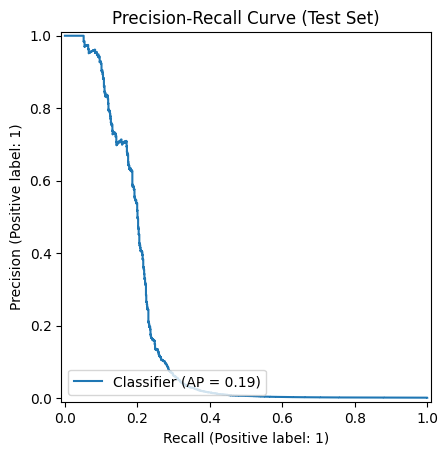

In [35]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        logits = model(batch.x_cat.to(device), batch.x_cont.to(device))
        y_true.extend(batch.y.numpy())
        y_pred.extend(torch.sigmoid(logits).cpu().numpy())

disp = PrecisionRecallDisplay.from_predictions(y_true, y_pred)
disp.ax_.set_title("Precision-Recall Curve (Test Set)")
plt.show()
